In [1]:
import numpy as np
import pandas as pd
import datetime

from scipy import stats
import statsmodels.api as sm
#from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def mean_absolute_percentage_error(y_true, y_pred,
                                   sample_weight=None,
                                   multioutput='uniform_average'):
    """
    В коллабе работает, локально нет, поэтому перенес реализацию из sklearn
    """
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            multioutput = None

    return np.average(output_errors, weights=multioutput)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
df = pd.read_csv('data/ads_hour.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y %H:%M')
df.head()

Date    ads
0 2017-08-03 00:00:00  49136
1 2017-08-03 01:00:00  46450
2 2017-08-03 02:00:00  46355
3 2017-08-03 03:00:00  43748
4 2017-08-03 04:00:00  42281

### Train test split (в test последние 30% наблюдений)

In [5]:
TEST_FRAC = 0.3

train_size = int(np.ceil(df.shape[0] * (1 - TEST_FRAC)))
train_df = df[:train_size]
test_df = df[train_size:]

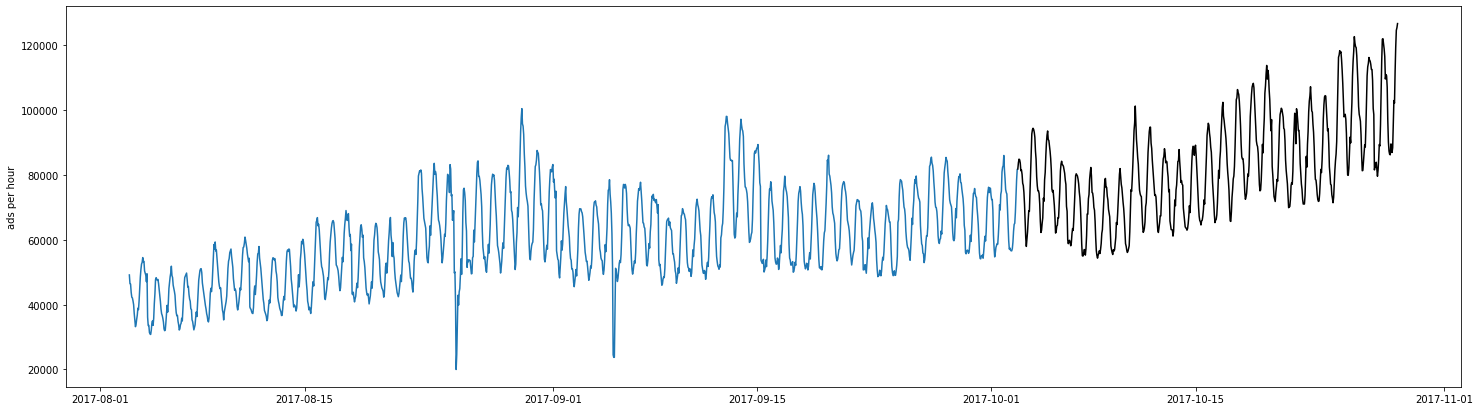

In [6]:
plt.figure(figsize=(25, 7))
plt.plot(train_df['Date'], train_df['ads'])
plt.plot(test_df['Date'], test_df['ads'], color='#000000')

plt.ylabel('ads per hour')
plt.show()

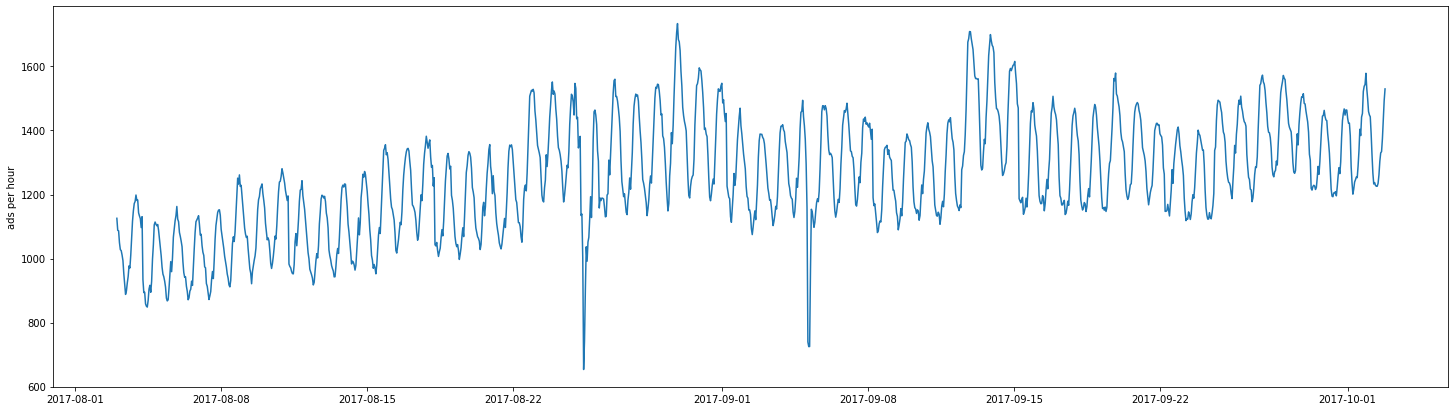

In [7]:
train_df['ads_bcox'], lmbd = stats.boxcox(train_df['ads'])

plt.figure(figsize=(25, 7))
plt.plot(train_df['Date'], train_df['ads_bcox'])

plt.ylabel('ads per hour')
plt.show()

In [8]:
# Обучение моделей с разными комбинациями вида тренда и сезонности

hw_add_model = ExponentialSmoothing(train_df['ads_bcox'],trend='add',seasonal='add',
                                            seasonal_periods=24*7).fit()
hw_mul_model = ExponentialSmoothing(train_df['ads_bcox'],trend='mul',seasonal='mul',
                                            seasonal_periods=24*7).fit()

hw_add_mul_model = ExponentialSmoothing(train_df['ads_bcox'],trend='add',seasonal='mul',
                                            seasonal_periods=24*7).fit()
# hw_mul_add_model = ExponentialSmoothing(train_df['ads_bcox'],trend='mul',seasonal='add',
#                                             seasonal_periods=24*7).fit()

In [9]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [10]:
train_df['ADD_tr_ADD_seas'] = invboxcox(hw_add_model.fittedvalues,lmbd)
train_df['MUL_tr_MUL_seas'] = invboxcox(hw_mul_model.fittedvalues,lmbd)
train_df['ADD_tr_MUL_seas'] = invboxcox(hw_add_mul_model.fittedvalues,lmbd)
# train_df['MUL_tr_ADD_seas'] = invboxcox(hw_mul_add_model.fittedvalues,lmbd)

### Визуальная проверка, что обучение прошло корректно

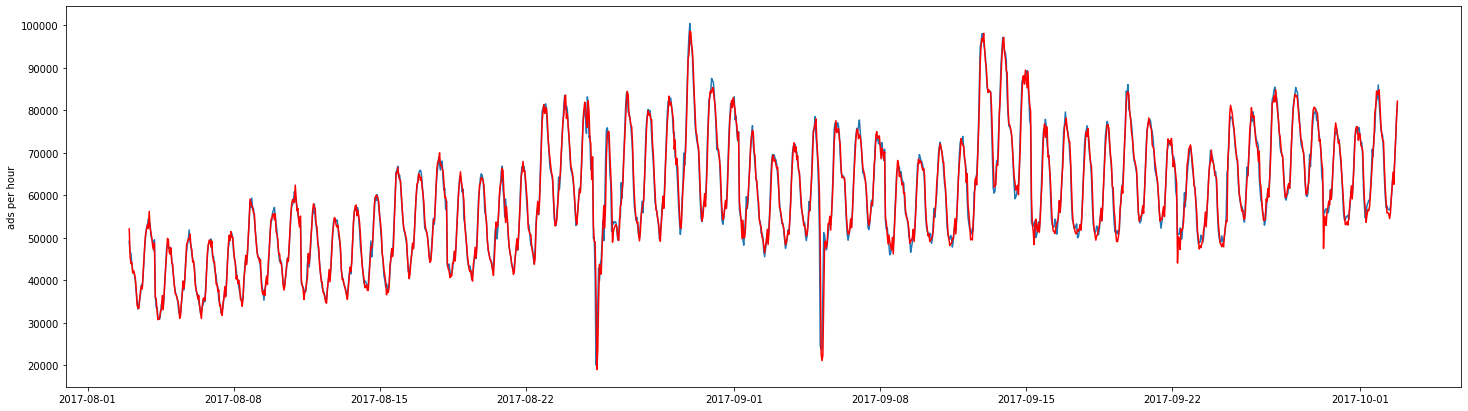

In [11]:
plt.figure(figsize=(25, 7))
plt.plot(train_df['Date'], train_df['ads'])
plt.plot(train_df['Date'], train_df['ADD_tr_ADD_seas'], color='r')

plt.ylabel('ads per hour')
plt.show()

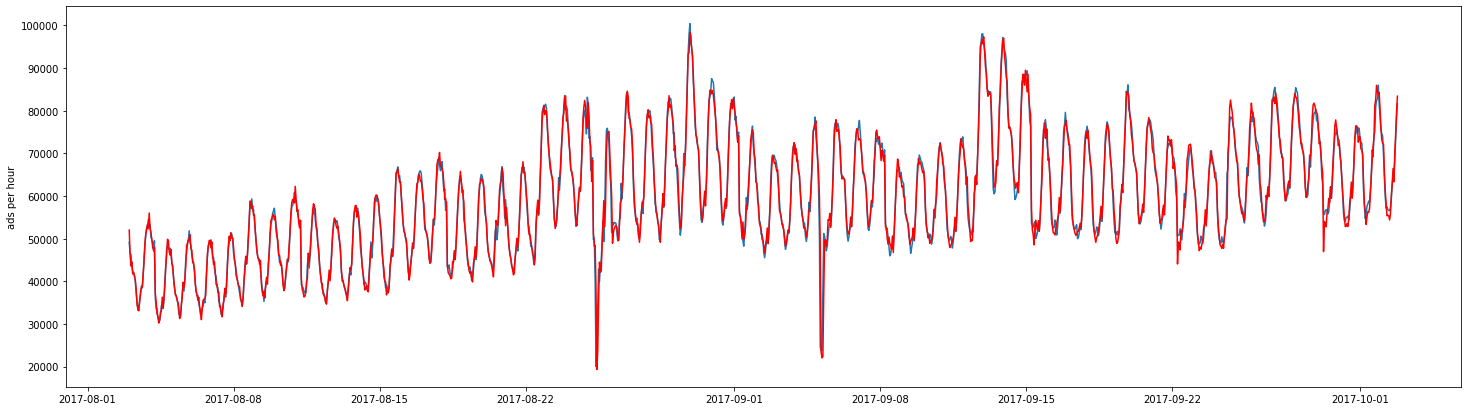

In [12]:
plt.figure(figsize=(25, 7))
plt.plot(train_df['Date'], train_df['ads'])
plt.plot(train_df['Date'], train_df['MUL_tr_MUL_seas'], color='r')

plt.ylabel('ads per hour')
plt.show()

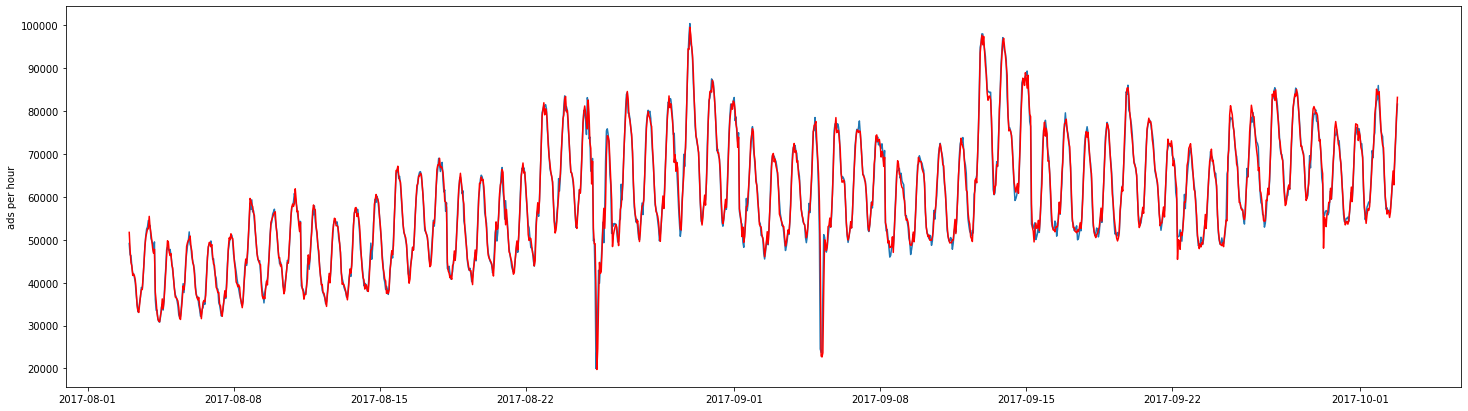

In [13]:
plt.figure(figsize=(25, 7))
plt.plot(train_df['Date'], train_df['ads'])
plt.plot(train_df['Date'], train_df['ADD_tr_MUL_seas'], color='r')

plt.ylabel('ads per hour')
plt.show()

### Прогноз для тестовой выборки

In [14]:
test_df['ADD_tr_ADD_seas'] = invboxcox(hw_add_model.forecast(test_df.shape[0]),lmbd)
test_df['MUL_tr_MUL_seas'] = invboxcox(hw_mul_model.forecast(test_df.shape[0]),lmbd)
test_df['ADD_tr_MUL_seas'] = invboxcox(hw_add_mul_model.forecast(test_df.shape[0]),lmbd)
# test_df['MUL_tr_ADD_seas'] = invboxcox(hw_mul_add_model.forecast(test_df.shape[0]),lmbd)

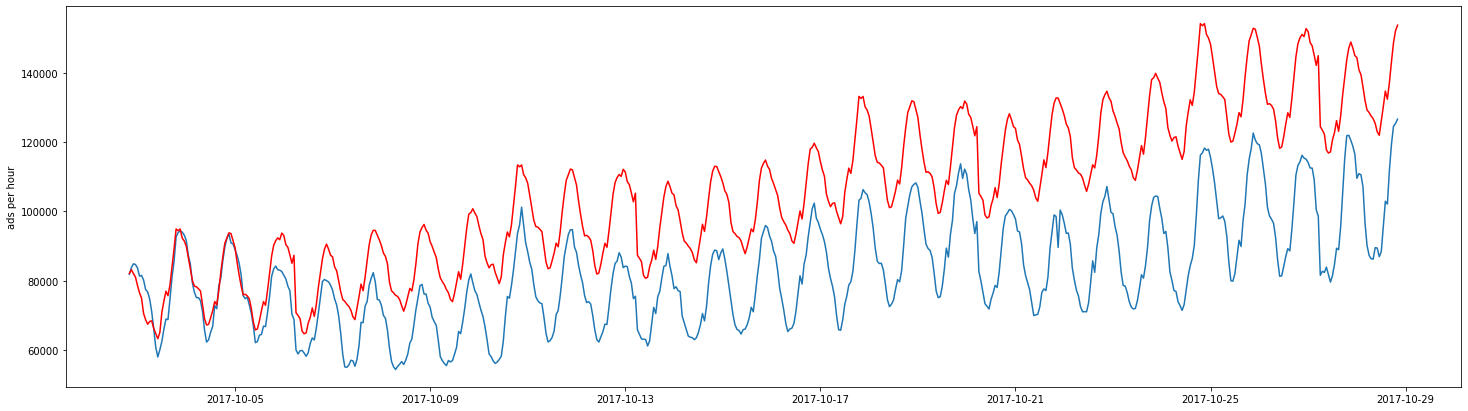

In [15]:
plt.figure(figsize=(25, 7))
plt.plot(test_df['Date'], test_df['ads'])
plt.plot(test_df['Date'], test_df['ADD_tr_ADD_seas'], color='r')

plt.ylabel('ads per hour')
plt.show()

In [16]:
print(f"MAPE HW ADD_tr_ADD_seas: {round(mean_absolute_percentage_error(test_df['ads'], test_df['ADD_tr_ADD_seas']) * 100, 2)}%") # Без bcox 61.49%

MAPE HW ADD_tr_ADD_seas: 27.95%


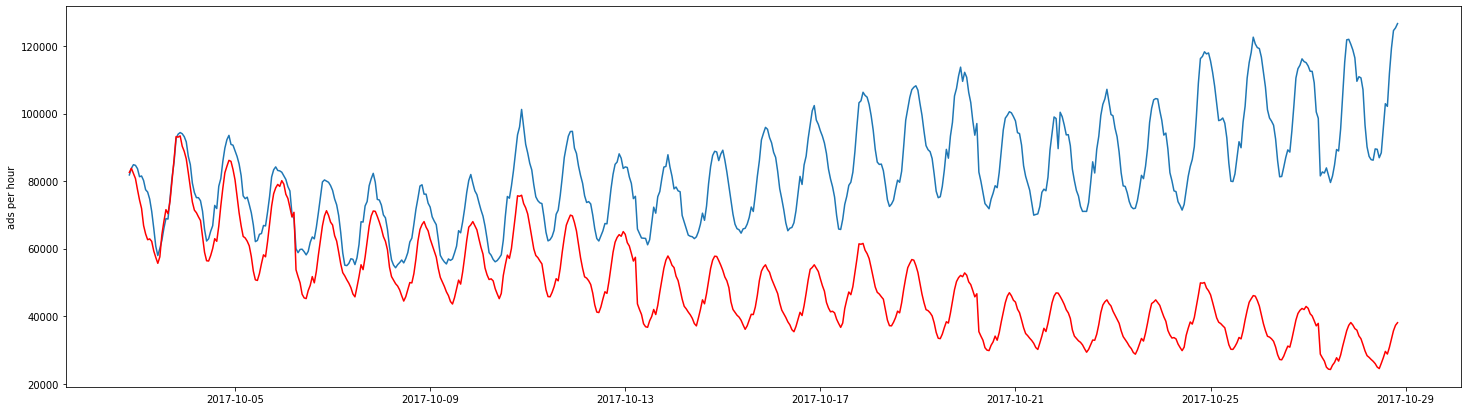

In [17]:
plt.figure(figsize=(25, 7))
plt.plot(test_df['Date'], test_df['ads'])
plt.plot(test_df['Date'], test_df['MUL_tr_MUL_seas'], color='r')

plt.ylabel('ads per hour')
plt.show()

In [18]:
print(f"MAPE MUL_tr_MUL_seas: {round(mean_absolute_percentage_error(test_df['ads'], test_df['MUL_tr_MUL_seas']) * 100, 2)}%") # Без bcox 31.21%

MAPE MUL_tr_MUL_seas: 38.63%


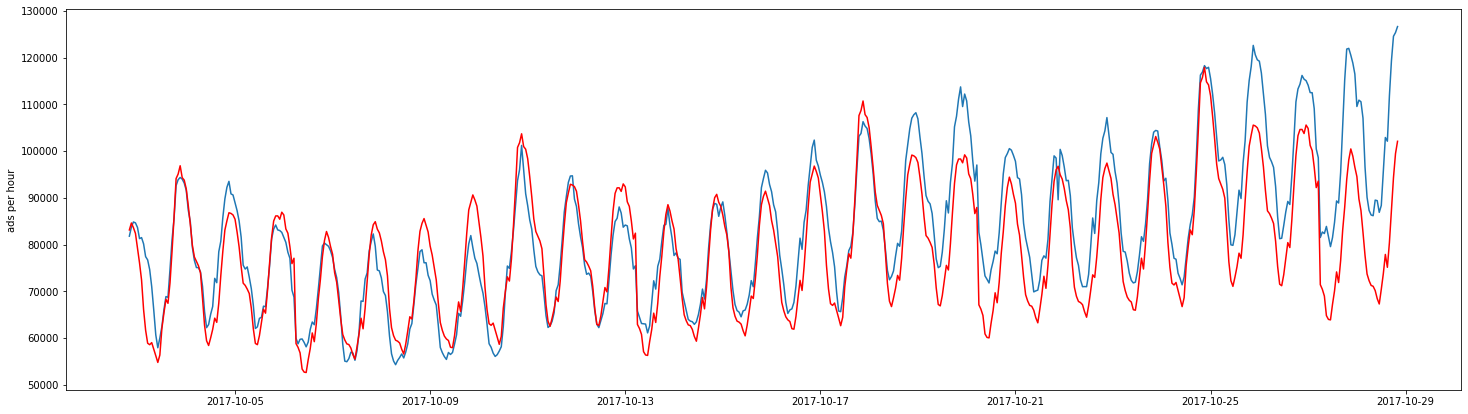

In [19]:
plt.figure(figsize=(25, 7))
plt.plot(test_df['Date'], test_df['ads'])
plt.plot(test_df['Date'], test_df['ADD_tr_MUL_seas'], color='r')

plt.ylabel('ads per hour')
plt.show()

In [20]:
print(f"MAPE ADD_tr_MUL_seas: {round(mean_absolute_percentage_error(test_df['ads'], test_df['ADD_tr_MUL_seas']) * 100, 2)}%") # Без bcox 34.88%

MAPE ADD_tr_MUL_seas: 7.47%
